In [9]:
# use alpaca as data api 
import os 
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from io import StringIO

import QuantLib as ql 

import plotly.graph_objects as go

import redis

import sys 
sys.path.append('..')

from src.kata_alpaca_engine.engine_utilities import (
    BackTestData,
download_data)

from src.kata_alpaca_engine.ingestion_engine import RedisTableUtility, Redis

In [10]:
STOCK_TICKER = "NVO"
SECRETS_PATH = ".secrets"
START_DATE = "2024-01-01"

In [11]:
df = download_data(SECRETS_PATH, START_DATE, symbols=STOCK_TICKER)

In [12]:
connection =  redis.Redis(host='red', port=6379)

In [13]:
connection

Redis<ConnectionPool<Connection<host=red,port=6379,db=0>>>

In [14]:
red_table = RedisTableUtility(connection)


In [15]:
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d').apply(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


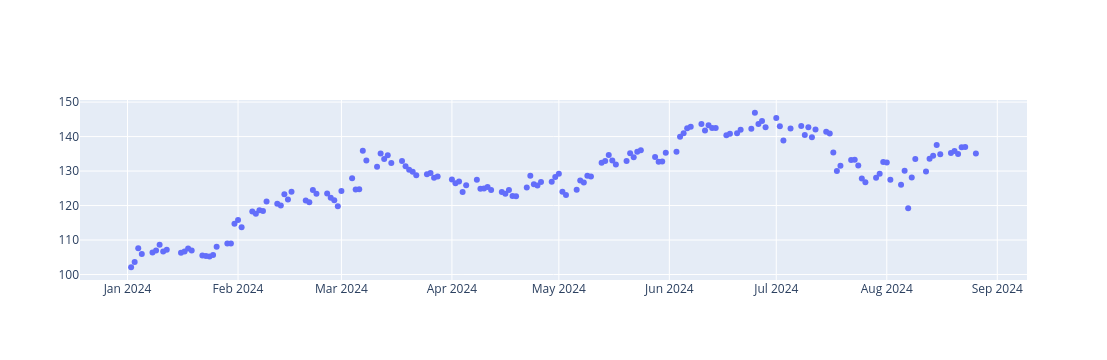

In [16]:

fig = go.Figure([go.Scatter(x=df['date'], 
                            y=df['price'], mode='markers')])

fig.show()


In [17]:
df['timestamp'] = df['date']

In [18]:

from src.kata_models.GaussianProcessModel import RegressionModel
from src.kata_models.GaussianProcessModel import K
from src.kata_models.GaussianProcessModel import OPTIMAL_KERNELS



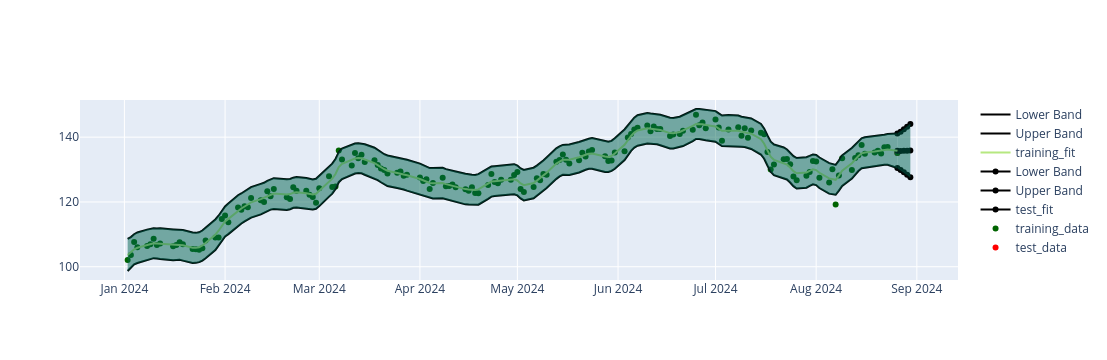

In [23]:
btest = BackTestData(df[['timestamp','price']])

btest.create_backtest_data(
    datetime(year=2024, month=1, day=1),
    datetime(year=2024, month=8, day=26), 
    ql.Date(30,8,2024),store_prices=True
)

def regression_fit(x,y): 


    SOME_KERNEL = 1.0 * K.ConstantKernel()\
        + 1.0 * K.WhiteKernel(noise_level=0.5)\
        + 1.0 * K.Matern(nu=0.75)


    return RegressionModel(x,y, kernels=SOME_KERNEL, random_state=2)


btest.fit_model(0, regression_fit)

yfit, ysigma = btest.predict(0) 
test_yfit , lower, upper = btest.create_bands(yfit, ysigma, band_factor= 2.32)
training_f, lower_f, upper_f = btest.training_bands(0, band_factor=2.32)


prediction_markers = go.Scatter(x=btest.prediction_data[0], 
                            y=btest.prediction_data_price[0], 
                            mode='markers',
                            marker=dict(color='red'),
                            name='test_data')

training_markers = go.Scatter(x=btest.data[0][0], 
                              y = btest.data[0][1],
                            mode='markers',
                            marker=dict(color='darkgreen'),
                            name='training_data')

xt = btest.prediction_data[0]
bands = [
go.Scatter(x=xt, y=test_yfit, line=dict(color='black', width=2), name='test_fit'),
go.Scatter(x=xt, y=upper, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=xt, y=lower, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
]

x = btest.data[0][0]
training_fit_bands = [
go.Scatter(x=x, y=training_f, name='training_fit'),
go.Scatter(x=x, y=upper_f, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=x, y=lower_f, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=x, y=upper_f, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=x, y=lower_f, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
] 


fig = go.Figure([prediction_markers, 
                 training_markers, 
                 *bands, 
                 *training_fit_bands
                 ])

fig.show()

In [20]:
btest = BackTestData(df[['timestamp','price']])

btest.create_backtest_data(
    datetime(year=2024, month=1, day=1),
    datetime(year=2024, month=7, day=15), 
    ql.Date(19,7,2024),store_prices=True
)

def regression_fit(x,y): 


    # SOME_KERNEL = 1.0 * K.ConstantKernel()\
    #     + 1.0 * K.WhiteKernel(noise_level=0.5)\
    #     + 1.0 * K.Matern(nu=0.75)

    SOME_KERNEL = 1.0 * K.ConstantKernel()\
    + 1.0 * K.RBF(2.0)\
    + 1.0 * K.WhiteKernel(noise_level=0.5) \
    + 1.0 * K.Matern(nu=0.5)


    return RegressionModel(x,y, kernels=SOME_KERNEL, random_state=2)


btest.fit_model(0, regression_fit)

yfit, ysigma = btest.predict(0) 
test_yfit , lower, upper = btest.create_bands(yfit, ysigma, band_factor= 2.32)
training_f, lower_f, upper_f = btest.training_bands(0, band_factor=2.32)


prediction_markers = go.Scatter(x=btest.prediction_data[0], 
                            y=btest.prediction_data_price[0], 
                            mode='markers',
                            marker=dict(color='red'),
                            name='test_data')

training_markers = go.Scatter(x=btest.data[0][0], 
                              y = btest.data[0][1],
                            mode='markers',
                            marker=dict(color='darkgreen'),
                            name='training_data')

xt = btest.prediction_data[0]
bands = [
go.Scatter(x=xt, y=test_yfit, line=dict(color='black', width=2), name='test_fit'),
go.Scatter(x=xt, y=upper, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=xt, y=lower, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
]

x = btest.data[0][0]
training_fit_bands = [
go.Scatter(x=x, y=training_f, name='training_fit'),
go.Scatter(x=x, y=upper_f, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=x, y=lower_f, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=x, y=upper_f, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=x, y=lower_f, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
] 


fig = go.Figure([prediction_markers, 
                 training_markers, 
                 *bands, 
                 *training_fit_bands
                 ])

fig.show()

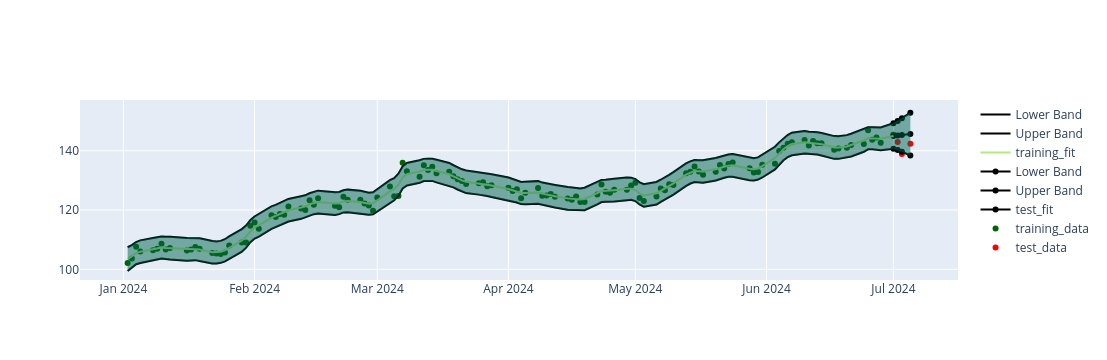

In [21]:
btest = BackTestData(df[['timestamp','price']])


btest.create_backtest_data(
    datetime(year=2024, month=1, day=1),
    datetime(year=2024, month=7, day=1), 
    ql.Date(5,7,2024),store_prices=True
)

def regression_fit(x,y): 


    # SOME_KERNEL = 1.0 * K.ConstantKernel()\
    #     + 1.0 * K.WhiteKernel(noise_level=0.5)\
    #     + 1.0 * K.Matern(nu=0.75)

    SOME_KERNEL = 1.0 * K.ConstantKernel()\
    + 1.0 * K.RBF(2.0)\
    + 1.0 * K.WhiteKernel(noise_level=0.5) \
    + 1.0 * K.Matern(nu=0.75)


    return RegressionModel(x,y, kernels=SOME_KERNEL, random_state=2)


btest.fit_model(0, regression_fit)

yfit, ysigma = btest.predict(0) 
test_yfit , lower, upper = btest.create_bands(yfit, ysigma, band_factor= 2.32)
training_f, lower_f, upper_f = btest.training_bands(0, band_factor=2.32)


prediction_markers = go.Scatter(x=btest.prediction_data[0], 
                            y=btest.prediction_data_price[0], 
                            mode='markers',
                            marker=dict(color='red'),
                            name='test_data')

training_markers = go.Scatter(x=btest.data[0][0], 
                              y = btest.data[0][1],
                            mode='markers',
                            marker=dict(color='darkgreen'),
                            name='training_data')

xt = btest.prediction_data[0]
bands = [
go.Scatter(x=xt, y=test_yfit, line=dict(color='black', width=2), name='test_fit'),
go.Scatter(x=xt, y=upper, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=xt, y=lower, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
]

x = btest.data[0][0]
training_fit_bands = [
go.Scatter(x=x, y=training_f, name='training_fit'),
go.Scatter(x=x, y=upper_f, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=x, y=lower_f, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=x, y=upper_f, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=x, y=lower_f, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
] 


fig = go.Figure([prediction_markers, 
                 training_markers, 
                 *bands, 
                 *training_fit_bands
                 ])

fig.show()

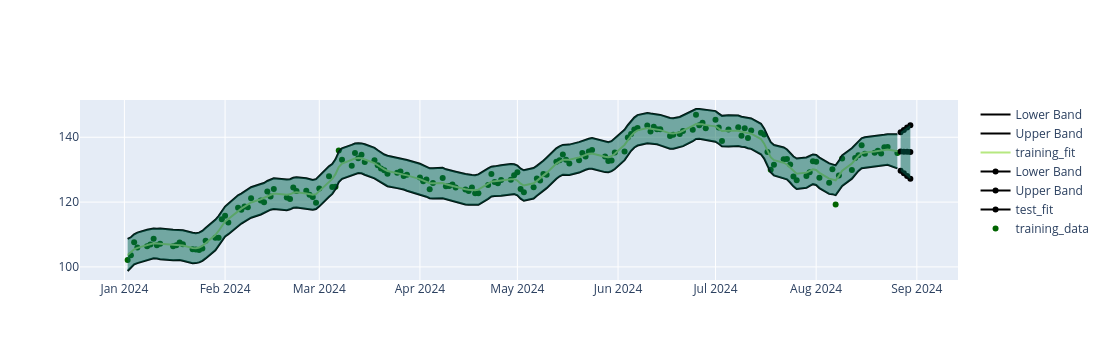

In [22]:
btest = BackTestData(df[['timestamp','price']])


btest.create_backtest_data(
    datetime(year=2024, month=1, day=1),
    datetime(year=2024, month=8, day=27), 
    ql.Date(30,8,2024),store_prices=True
)

def regression_fit(x,y): 


    # SOME_KERNEL = 1.0 * K.ConstantKernel()\
    #     + 1.0 * K.WhiteKernel(noise_level=0.5)\
    #     + 1.0 * K.Matern(nu=0.75)

    SOME_KERNEL = 1.0 * K.ConstantKernel()\
    + 1.0 * K.RBF(1.0)\
    + 1.0 * K.WhiteKernel(noise_level=0.5) \
    + 1.0 * K.Matern(nu=0.75)


    return RegressionModel(x,y, kernels=SOME_KERNEL, random_state=2)


btest.fit_model(0, regression_fit)

yfit, ysigma = btest.predict(0) 
test_yfit , lower, upper = btest.create_bands(yfit, ysigma, band_factor= 2.32)
training_f, lower_f, upper_f = btest.training_bands(0, band_factor=2.32)


prediction_markers = go.Scatter(x=btest.prediction_data[0], 
                            y=btest.prediction_data_price[0], 
                            mode='markers',
                            marker=dict(color='red'),
                            name='test_data')

training_markers = go.Scatter(x=btest.data[0][0], 
                              y = btest.data[0][1],
                            mode='markers',
                            marker=dict(color='darkgreen'),
                            name='training_data')

xt = btest.prediction_data[0]
bands = [
go.Scatter(x=xt, y=test_yfit, line=dict(color='black', width=2), name='test_fit'),
go.Scatter(x=xt, y=upper, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=xt, y=lower, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
]

x = btest.data[0][0]
training_fit_bands = [
go.Scatter(x=x, y=training_f, name='training_fit'),
go.Scatter(x=x, y=upper_f, line=dict(color='black', width=2), name='Upper Band'),
go.Scatter(x=x, y=lower_f, line=dict(color='black', width=2), name='Lower Band'),
go.Scatter(x=x, y=upper_f, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
go.Scatter(x=x, y=lower_f, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
] 


fig = go.Figure([prediction_markers, 
                 training_markers, 
                 *bands, 
                 *training_fit_bands
                 ])

fig.show()